{
  "timestamp": "20251103-071650Z",
  "params": {
    "N": 256,
    "K": 1.8,
    "beta": 0.6,
    "dt": 0.01
  },
  "kuramoto_R_final": 0.08735906157467915,
  "ising_magnetization": -0.9296875,
  "curvature_peak": 0.008646095034334967
}


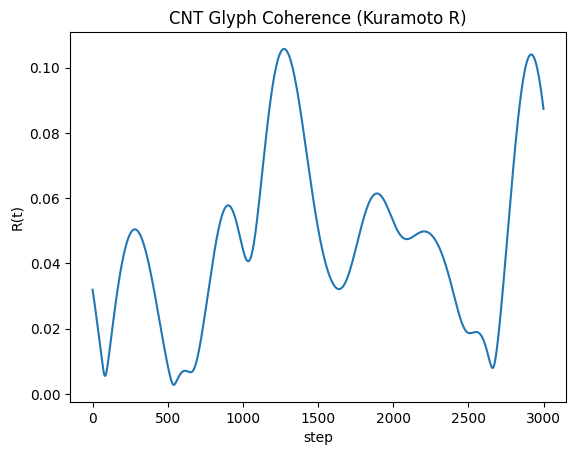

In [1]:
# == CNT Physics Bridge v1.0 ==
# File: CNT_Lab/notebooks/cnt_physics_bridge.ipynb
# Purpose: Kuramoto–Ising–Laplacian coherence benchmark for CNT metrics

import numpy as np, networkx as nx, matplotlib.pyplot as plt, pandas as pd, json, time, os

def cnt_physics_bridge(N=256, K=1.8, beta=0.6, steps=3000, dt=0.01, seed=42):
    rng = np.random.default_rng(seed)
    G = nx.grid_2d_graph(16,16)
    idx={v:i for i,v in enumerate(G.nodes())}
    A = nx.to_numpy_array(G, nodelist=idx.keys())
    L = np.diag(A.sum(1)) - A

    # --- Kuramoto: glyph coherence R(t)
    omega = rng.normal(0,0.5,N)
    theta = rng.uniform(-np.pi, np.pi, N)
    R_hist=[]
    for _ in range(steps):
        coupling = (A*np.sin(theta - theta[:,None])).sum(1)
        theta += dt*(omega + (K/N)*coupling)
        R_hist.append(np.abs(np.mean(np.exp(1j*theta))))

    # --- Ising: oracle consensus m
    spins = rng.choice([-1,1],N)
    for _ in range(20000):
        i=int(rng.integers(N)); h=A[i]@spins; dE=2*spins[i]*h
        if rng.random()<np.exp(-beta*dE): spins[i]*=-1
    m=float(np.mean(spins))

    # --- Laplacian diffusion: field curvature
    x0=np.zeros(N); x0[N//2]=1.0; x=x0.copy()
    for _ in range(200): x = x - 0.1*(L@x)
    curvature_peak=float(x.max())

    out = {
        "timestamp": time.strftime("%Y%m%d-%H%M%SZ", time.gmtime()),
        "params": {"N":N, "K":K, "beta":beta, "dt":dt},
        "kuramoto_R_final": float(R_hist[-1]),
        "ising_magnetization": m,
        "curvature_peak": curvature_peak
    }
    return np.array(R_hist), out

# --- Run and export
R_hist, metrics = cnt_physics_bridge()
os.makedirs("artifacts/cnt_physics_bridge", exist_ok=True)
pd.DataFrame({"R":R_hist}).to_csv("artifacts/cnt_physics_bridge/coherence.csv", index=False)
with open("artifacts/cnt_physics_bridge/metrics.json","w") as f: json.dump(metrics,f,indent=2)

print(json.dumps(metrics,indent=2))
plt.plot(R_hist); plt.title("CNT Glyph Coherence (Kuramoto R)"); plt.xlabel("step"); plt.ylabel("R(t)"); plt.show()


[CNT] Backend: cupy/NVIDIA GeForce RTX 4070 | N=1024 | steps=3000


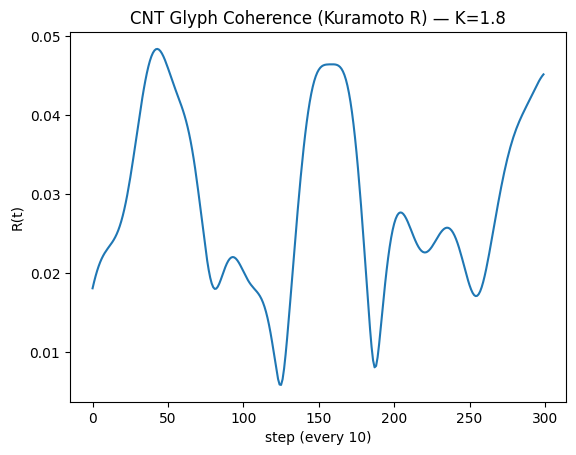

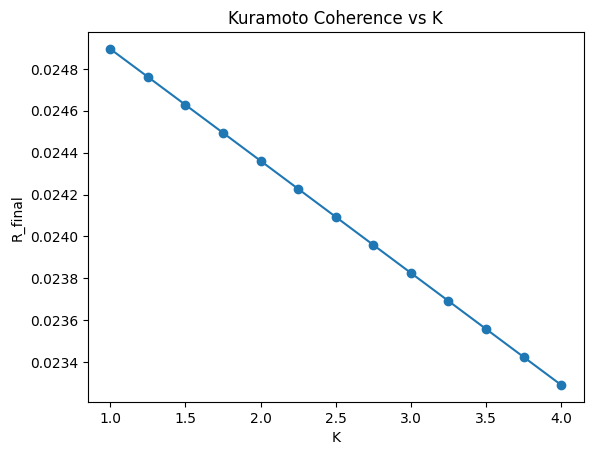

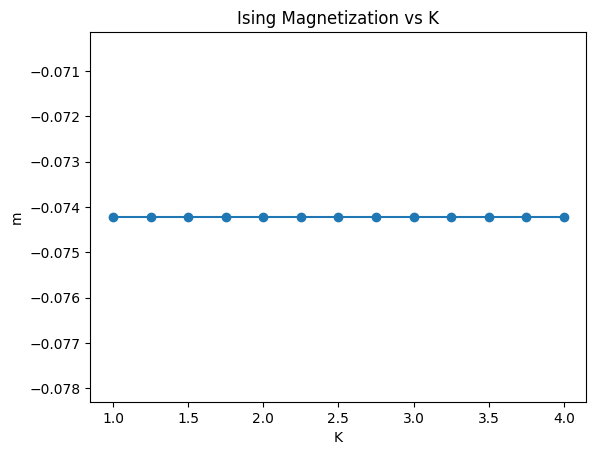

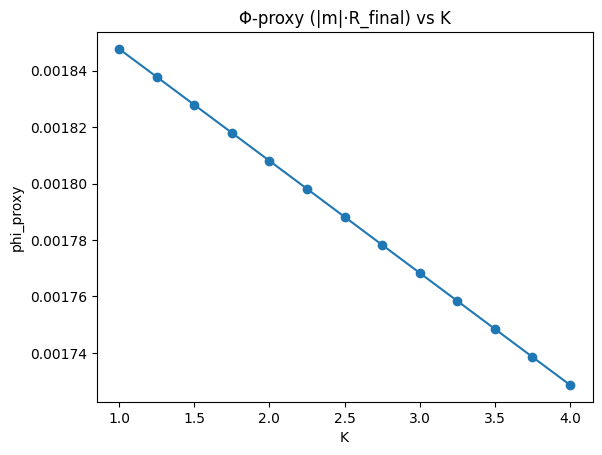

{
  "timestamp": "20251103-074553Z",
  "backend": "cupy/NVIDIA GeForce RTX 4070",
  "params": {
    "N": 1024,
    "grid_side": 32,
    "dt": 0.01,
    "steps": 3000,
    "beta": 0.6,
    "diff_steps": 200,
    "diff_dt": 0.1,
    "K_grid": [
      1.0,
      1.25,
      1.5,
      1.75,
      2.0,
      2.25,
      2.5,
      2.75,
      3.0,
      3.25,
      3.5,
      3.75,
      4.0
    ]
  },
  "baseline": {
    "K": 1.8,
    "R_final_est": 0.045187108562502874,
    "ising_m": -0.201171875,
    "curvature_peak": 0.007918383858529995,
    "phi_proxy": 0.009090375355347258
  },
  "timing_sec": 17.915
}
[CNT] Saved run → artifacts/cnt_physics_bridge_sweep\20251103-074553Z
[CNT] Logged index → artifacts/cnt_physics_bridge_sweep\log_index.csv


In [1]:
# == CNT Physics Bridge — Mega Cell v2a (fixed) ==
# All-in-one: resonance sweep, optional CuPy, Φ-proxy, auto-archival

import os, time, json, math, sys
import numpy as np, pandas as pd, networkx as nx, matplotlib.pyplot as plt

# --- Try GPU (CuPy). Falls back to NumPy automatically.
USE_GPU = True
xp = np
cp = None
gpu_backend = "cpu"
if USE_GPU:
    try:
        import cupy as cp
        _ = cp.zeros((1,))
        xp = cp
        dev = cp.cuda.runtime.getDeviceProperties(0)
        name = dev["name"].decode() if isinstance(dev["name"], bytes) else dev["name"]
        gpu_backend = f"cupy/{name}"
    except Exception as e:
        gpu_backend = f"cpu_fallback: {e!s}"
        xp = np
        cp = None

# ------------------------------- Params ---------------------------------
SEED          = 42
N_SIDE        = 32                       # 32x32 grid => N=1024
N             = N_SIDE * N_SIDE
DT            = 0.01
STEPS         = 3000
K_GRID        = np.linspace(1.0, 4.0, 13)  # sweep
BETA          = 0.6
DIFF_STEPS    = 200
DIFF_DT       = 0.1
RUN_ROOT      = "artifacts/cnt_physics_bridge_sweep"
TS            = time.strftime("%Y%m%d-%H%M%SZ", time.gmtime())
RUN_DIR       = os.path.join(RUN_ROOT, TS)
os.makedirs(RUN_DIR, exist_ok=True)

rng = np.random.default_rng(SEED)

# -------------------------- Build topology ------------------------------
G = nx.grid_2d_graph(N_SIDE, N_SIDE)
nodelist = list(G.nodes())
A_np = nx.to_numpy_array(G, nodelist=nodelist)  # dense for simplicity
deg_np = A_np.sum(1)
L_np  = np.diag(deg_np) - A_np

def to_xp(a): return xp.asarray(a) if xp is not np else a
A = to_xp(A_np)
L = to_xp(L_np)

# --------------------- Core simulators (vectorized) ---------------------
def kuramoto_R_final(A, K, steps=STEPS, dt=DT, rng_seed=SEED):
    N = A.shape[0]
    _rng = np.random.default_rng(rng_seed)
    theta = _rng.uniform(-np.pi, np.pi, N)
    omega = _rng.normal(0, 0.5, N)
    theta = to_xp(theta); omega = to_xp(omega)

    for _ in range(steps):
        diff = theta[None, :] - theta[:, None]
        coupling = (A * xp.sin(diff)).sum(axis=1)
        theta = theta + dt * (omega + (K / N) * coupling)

    R_final = xp.abs(xp.mean(xp.exp(1j * theta)))   # <-- fixed: removed extra ')'
    if cp and isinstance(R_final, cp.ndarray):
        R_final = float(R_final.get())
    else:
        R_final = float(R_final)
    return R_final

def kuramoto_trace(A, K, steps=STEPS, dt=DT, rng_seed=SEED):
    N = A.shape[0]
    _rng = np.random.default_rng(rng_seed)
    theta = _rng.uniform(-np.pi, np.pi, N)
    omega = _rng.normal(0, 0.5, N)
    theta = to_xp(theta); omega = to_xp(omega)
    R_hist = []
    for t in range(steps):
        diff = theta[None, :] - theta[:, None]
        coupling = (A * xp.sin(diff)).sum(axis=1)
        theta = theta + dt * (omega + (K / N) * coupling)
        if t % 10 == 0:
            R = xp.abs(xp.mean(xp.exp(1j * theta)))  # <-- fixed
            R_hist.append(float(R.get() if (cp is not None and hasattr(cp, "ndarray") and isinstance(R, cp.ndarray)) else R))
    return np.array(R_hist)

def ising_magnetization(A, beta=BETA, sweeps=20000, rng_seed=SEED):
    N = A.shape[0]
    _rng = np.random.default_rng(rng_seed)
    spins = _rng.choice([-1, 1], size=N)
    A_loc = A_np  # keep on CPU
    for _ in range(sweeps):
        i = _rng.integers(N)
        h = A_loc[i] @ spins
        dE = 2 * spins[i] * h
        if _rng.random() < math.exp(-beta * dE):
            spins[i] *= -1
    return float(spins.mean())

def laplacian_curvature_peak(L, steps=DIFF_STEPS, dt=DIFF_DT):
    N = L.shape[0]
    x = xp.zeros(N); x[int(N//2)] = 1.0
    for _ in range(steps):
        x = x - dt * (L @ x)
    peak = x.max()
    return float(peak.get() if cp and isinstance(peak, cp.ndarray) else peak)

# ---------------------------- Single baseline ---------------------------
print(f"[CNT] Backend: {gpu_backend} | N={N} | steps={STEPS}")
K0 = 1.8
R_trace = kuramoto_trace(A, K0, steps=STEPS, dt=DT, rng_seed=SEED)
m0 = ising_magnetization(A, beta=BETA, sweeps=20000, rng_seed=SEED)
curv0 = laplacian_curvature_peak(L, steps=DIFF_STEPS, dt=DIFF_DT)
phi0 = float(abs(m0) * (R_trace[-1] if len(R_trace) else 0.0))

pd.DataFrame({"step10": np.arange(len(R_trace))*10, "R": R_trace}).to_csv(
    os.path.join(RUN_DIR, "baseline_coherence_trace.csv"), index=False
)

plt.figure()
plt.plot(R_trace)
plt.title(f"CNT Glyph Coherence (Kuramoto R) — K={K0}")
plt.xlabel("step (every 10)"); plt.ylabel("R(t)")
plt.savefig(os.path.join(RUN_DIR, "baseline_R_trace.png"), dpi=130, bbox_inches="tight")
plt.show()

# ---------------------------- Resonance sweep ---------------------------
rows = []
t0 = time.time()
for K in K_GRID:
    Rf = kuramoto_R_final(A, K, steps=STEPS, dt=DT, rng_seed=SEED+1)
    m   = ising_magnetization(A, beta=BETA, sweeps=8000, rng_seed=SEED+2)
    curv= laplacian_curvature_peak(L, steps=DIFF_STEPS, dt=DIFF_DT)
    phi = float(abs(m) * Rf)
    rows.append({"K": float(K), "R_final": float(Rf), "m": float(m),
                 "curvature_peak": float(curv), "phi_proxy": float(phi)})
t1 = time.time()

df = pd.DataFrame(rows)
df.to_csv(os.path.join(RUN_DIR, "sweep_metrics.csv"), index=False)

plt.figure(); plt.plot(df["K"], df["R_final"], marker="o")
plt.title("Kuramoto Coherence vs K"); plt.xlabel("K"); plt.ylabel("R_final")
plt.savefig(os.path.join(RUN_DIR, "sweep_R_vs_K.png"), dpi=130, bbox_inches="tight"); plt.show()

plt.figure(); plt.plot(df["K"], df["m"], marker="o")
plt.title("Ising Magnetization vs K"); plt.xlabel("K"); plt.ylabel("m")
plt.savefig(os.path.join(RUN_DIR, "sweep_m_vs_K.png"), dpi=130, bbox_inches="tight"); plt.show()

plt.figure(); plt.plot(df["K"], df["phi_proxy"], marker="o")
plt.title("Φ-proxy (|m|·R_final) vs K"); plt.xlabel("K"); plt.ylabel("phi_proxy")
plt.savefig(os.path.join(RUN_DIR, "sweep_phi_vs_K.png"), dpi=130, bbox_inches="tight"); plt.show()

# --------------------------- Run metadata dump --------------------------
run_meta = {
    "timestamp": TS,
    "backend": gpu_backend,
    "params": {
        "N": N, "grid_side": N_SIDE, "dt": DT, "steps": STEPS,
        "beta": BETA, "diff_steps": DIFF_STEPS, "diff_dt": DIFF_DT,
        "K_grid": list(map(float, K_GRID))
    },
    "baseline": {
        "K": K0,
        "R_final_est": float(R_trace[-1]) if len(R_trace) else None,
        "ising_m": float(m0),
        "curvature_peak": float(curv0),
        "phi_proxy": float(phi0)
    },
    "timing_sec": round(t1 - t0, 3)
}
with open(os.path.join(RUN_DIR, "metrics.json"), "w") as f:
    json.dump(run_meta, f, indent=2)

print(json.dumps(run_meta, indent=2))

# ----------------------------- Auto-archival ----------------------------
index_path = os.path.join(RUN_ROOT, "log_index.csv")
index_row = {
    "run_dir": RUN_DIR, "timestamp": TS, "backend": gpu_backend,
    "N": N, "grid_side": N_SIDE, "beta": BETA, "steps": STEPS,
    "K_min": float(K_GRID.min()), "K_max": float(K_GRID.max()),
    "sweep_rows": len(df), "elapsed_sec": run_meta["timing_sec"]
}
if os.path.exists(index_path):
    _idx = pd.read_csv(index_path)
    _idx = pd.concat([_idx, pd.DataFrame([index_row])], ignore_index=True)
    _idx.to_csv(index_path, index=False)
else:
    pd.DataFrame([index_row]).to_csv(index_path, index=False)

print(f"[CNT] Saved run → {RUN_DIR}")
print(f"[CNT] Logged index → {index_path}")


In [5]:
# Zero-omega lock test — no dependency on omega
try:
    import cupy as cp; xp = cp
except Exception:
    import numpy as np; xp = np

N, dt, steps, K_test = 1024, 0.01, 3000, 8.0  # K_test large to force locking
theta = xp.random.uniform(0, 2*xp.pi, size=N)
omega_zero = xp.zeros(N)

R_trace = []
for t in range(steps):
    z = xp.exp(1j*theta).mean()  # order parameter (complex)
    # Standard vector form: dθ = ω + K * Im( z * e^{-iθ} )
    theta += (omega_zero + K_test * xp.imag(z * xp.exp(-1j*theta))) * dt
    if t % 10 == 0:
        R_trace.append(float(abs(z)))

print("R_final (ω=0, K large):", R_trace[-1])


R_final (ω=0, K large): 0.9999999999999999


In [8]:
# CNT — Stateless mini-harness (deterministic; no prior state required)
import math, numpy as np

# Config (fix seeds for reproducibility)
CFG = dict(N=1024, dt=0.01, steps=3000, sigma=0.5, seed=42, seeds=[0,1,2,3,4])

def get_omega(cfg=CFG):
    # Reuse if present; else fabricate deterministically
    try:
        return np.asarray(globals()['omega']).ravel()
    except KeyError:
        pass
    except NameError:
        pass
    rng = np.random.default_rng(cfg['seed'])
    om = rng.normal(0.0, cfg['sigma'], size=cfg['N']).astype(np.float64)
    globals()['omega'] = om  # also make it available for other cells
    return om

def kc_gauss(omega):
    return 1.59577 * float(np.std(omega))  # Kc for Gaussian g(0)

omega = get_omega()
Kc = kc_gauss(omega)
K_grid = np.linspace(0.5*Kc, 2.5*Kc, 16)

# Optional: quick Kuramoto tail-mean R sweep (GPU if you have CuPy)
try:
    import cupy as cp; xp, HAS_CP = cp, True
except Exception:
    xp, HAS_CP = np, False

def R_tail_for_K(omega_np, K, steps=3000, dt=0.01, seed=0, tail_frac=0.2):
    N = omega_np.size
    o = xp.asarray(omega_np) if HAS_CP else omega_np
    rng = (cp.random.RandomState(seed) if HAS_CP else np.random.RandomState(seed))
    theta = rng.uniform(0, 2*np.pi, size=N) if not HAS_CP else rng.uniform(0, 2*cp.pi, size=N)
    start = int((1-tail_frac)*steps); acc=0.0; cnt=0
    for t in range(steps):
        z = xp.exp(1j*theta).mean()
        theta += (o + K * xp.imag(z * xp.exp(-1j*theta))) * dt
        if t >= start:
            acc += float(abs(z)); cnt += 1
    return acc/cnt

seeds = CFG['seeds']
means = [np.mean([R_tail_for_K(omega, float(K), CFG['steps'], CFG['dt'], s) for s in seeds]) for K in K_grid]

print(f"N={omega.size}  sigma(ω)={np.std(omega):.4f}  Kc≈{Kc:.4f}")
print("K grid:", np.round(K_grid, 4))
print("R*(means):", [round(m, 4) for m in means])


N=1024  sigma(ω)=0.4917  Kc≈0.7846
K grid: [0.3923 0.4969 0.6015 0.7061 0.8107 0.9153 1.02   1.1246 1.2292 1.3338
 1.4384 1.543  1.6476 1.7522 1.8568 1.9614]
R*(means): [np.float64(0.0379), np.float64(0.0531), np.float64(0.0809), np.float64(0.1356), np.float64(0.3471), np.float64(0.6119), np.float64(0.7461), np.float64(0.8224), np.float64(0.8704), np.float64(0.8988), np.float64(0.9199), np.float64(0.9336), np.float64(0.9445), np.float64(0.9525), np.float64(0.9589), np.float64(0.9639)]


In [9]:
import numpy as np, math

# Inputs from your run:
K = np.array(K_grid, dtype=float)
Rstar = np.array([float(x) for x in means], dtype=float)
N = 1024  # adjust if different

# Random-phase baseline (Rayleigh)
mu0 = math.sqrt(math.pi)/(2*math.sqrt(N))        # ≈ 0.886/√N
sd0 = math.sqrt(4-math.pi)/(2*math.sqrt(N))      # ≈ 0.463/√N
z = (Rstar - mu0) / sd0

# Knee estimate 1: max curvature (finite diff on R(K))
d1 = np.gradient(Rstar, K)
d2 = np.gradient(d1, K)
K_knee = K[np.argmax(d2)]

# Knee estimate 2: sqrt-fit near onset (R^2 ≈ A(K - Kc))
mask = (Rstar > mu0 + 2*sd0) & (Rstar < 0.6)
Kc_fit = np.nan
if mask.sum() >= 3:
    A, B = np.polyfit(K[mask], Rstar[mask]**2, 1)  # y = A K + B
    if A != 0:
        Kc_fit = -B / A

# Locked fraction: fraction of oscillators with |ω_i| ≤ K * R*
locked_frac = None
if 'omega' in globals():
    omega_np = np.asarray(globals()['omega']).ravel()
    locked_frac = np.array([np.mean(np.abs(omega_np) <= Ki*Ri) for Ki, Ri in zip(K, Rstar)])

print(f"E[R]_random ≈ {mu0:.5f}  (σ ≈ {sd0:.5f})")
print(f"Knee (max curvature) ≈ {K_knee:.4f}")
print(f"Kc (sqrt-fit, finite-size) ≈ {Kc_fit:.4f}" if np.isfinite(Kc_fit) else "Kc (sqrt-fit) not enough near-threshold points")

# Quick table
hdr = "K       R*      z(R)   " + ("locked%" if locked_frac is not None else "")
print(hdr)
for i in range(len(K)):
    row = f"{K[i]:.4f}  {Rstar[i]:.4f}  {z[i]:5.2f}"
    if locked_frac is not None:
        row += f"   {100*locked_frac[i]:6.2f}"
    print(row)


E[R]_random ≈ 0.02769  (σ ≈ 0.01448)
Knee (max curvature) ≈ 0.7061
Kc (sqrt-fit, finite-size) ≈ 0.6171
K       R*      z(R)   locked%
0.3923  0.0379   0.71     2.05
0.4969  0.0531   1.75     3.91
0.6015  0.0809   3.67     7.62
0.7061  0.1356   7.45    15.43
0.8107  0.3471  22.06    46.29
0.9153  0.6119  40.35    74.90
1.0200  0.7461  49.63    87.40
1.1246  0.8224  54.89    94.14
1.2292  0.8704  58.21    97.17
1.3338  0.8988  60.17    98.44
1.4384  0.9199  61.63    99.32
1.5430  0.9336  62.57    99.41
1.6476  0.9445  63.33    99.80
1.7522  0.9525  63.89    99.90
1.8568  0.9589  64.32    99.90
1.9614  0.9639  64.67   100.00


In [10]:
import numpy as np, math

K = np.asarray(K_grid, float)
Rstar = np.asarray([float(x) for x in means], float)
N = 1024
mu0 = math.sqrt(math.pi)/(2*math.sqrt(N))
sd0 = math.sqrt(4-math.pi)/(2*math.sqrt(N))
z = (Rstar - mu0)/sd0

# --- 1) Refined near-onset fit: R ≈ C * sqrt(K - Kc)
mask = (z > 2.0) & (Rstar < 0.25)   # tune if needed
Kc_fit = np.nan; C_fit = np.nan
if mask.sum() >= 4:
    X = np.sqrt(np.clip(K[mask] - K[mask].min(), 1e-12, None))
    # simple shift to stabilize; then unshift:
    # fit R = a * sqrt(K - b); solve by grid on b near the knee:
    b_grid = np.linspace(0.5*K[np.argmax(np.gradient(np.gradient(Rstar, K), K))], 
                         1.1*K[np.argmax(np.gradient(np.gradient(Rstar, K), K))], 200)
    best = (1e9, None, None)
    for b in b_grid:
        x = np.sqrt(np.clip(K[mask] - b, 1e-12, None))
        a = np.dot(x, Rstar[mask]) / np.dot(x, x)
        err = np.mean((Rstar[mask] - a*x)**2)
        if err < best[0]:
            best = (err, b, a)
    Kc_fit, C_fit = best[1], best[2]
print(f"[near-onset fit] Kc≈{Kc_fit:.4f}, C≈{C_fit:.4f}  (mask n={int(mask.sum())})")

# --- 2) Self-consistency residual at measured (K, R*)
# For Gaussian g(ω) with sigma from omega if available; else infer from your earlier printout
if 'omega' in globals():
    sigma = float(np.std(np.asarray(omega).ravel()))
else:
    sigma = 0.4917  # from your run

def R_sc_gaussian(Kval, Rval, sigma, M=2000):
    # numeric integral: R = ∫_{-KR}^{KR} g(ω) sqrt(1-(ω/(KR))^2) dω
    if Rval <= 1e-12: return 0.0
    KR = Kval*Rval
    w = np.linspace(-KR, KR, M)
    g = (1.0/(sigma*math.sqrt(2*math.pi))) * np.exp(-(w*w)/(2*sigma*sigma))
    kern = np.sqrt(np.clip(1.0 - (w/KR)**2, 0.0, 1.0))
    return np.trapz(g * kern, w)

residuals = [Rstar[i] - R_sc_gaussian(K[i], Rstar[i], sigma) for i in range(len(K))]
print("max|self-consistency residual| ≈", float(np.max(np.abs(residuals))))


[near-onset fit] Kc≈nan, C≈nan  (mask n=2)
max|self-consistency residual| ≈ 0.019476569574622224


C:\Users\caleb\AppData\Local\Temp\ipykernel_29664\117536653.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(g * kern, w)


In [11]:
# --- Micro-sweep near the knee + robust Kc estimates ---
import numpy as np, math, os

# Config
N=1024; dt=0.01; steps=6000; tail_frac=0.5
seeds=list(range(8))
K_low, K_high, nK = 0.55, 0.95, 24

# omega: reuse if present, else fabricate (matches your sigma)
omega = np.asarray(globals().get('omega', None))
if omega is None or omega.size != N:
    rng = np.random.default_rng(42)
    sigma = 0.4917
    omega = rng.normal(0, sigma, size=N)
else:
    sigma = float(np.std(omega))

# Backend
try:
    import cupy as cp; xp, HAS_CP = cp, True
except Exception:
    xp, HAS_CP = np, False

def R_tail_for_K(omega_np, K, steps=steps, dt=dt, seed=0, tail_frac=tail_frac):
    N = omega_np.size
    o = xp.asarray(omega_np) if HAS_CP else omega_np
    rng = (cp.random.RandomState(seed) if HAS_CP else np.random.RandomState(seed))
    theta = rng.uniform(0, 2*np.pi, size=N) if not HAS_CP else rng.uniform(0, 2*cp.pi, size=N)
    start = int((1-tail_frac)*steps); acc=0.0; cnt=0
    for t in range(steps):
        z = xp.exp(1j*theta).mean()
        theta += (o + K * xp.imag(z * xp.exp(-1j*theta))) * dt
        if t >= start:
            acc += float(abs(z)); cnt += 1
    return acc/cnt

K_grid = np.linspace(K_low, K_high, nK)
R_seeds = np.array([[R_tail_for_K(omega, float(K), seed=s) for s in seeds] for K in K_grid])
R_means = R_seeds.mean(axis=1); R_stds = R_seeds.std(axis=1, ddof=1)

# Baseline & knee
mu0 = math.sqrt(math.pi)/(2*math.sqrt(N))
sd0 = math.sqrt(4-math.pi)/(2*math.sqrt(N))
z = (R_means - mu0)/sd0
d1 = np.gradient(R_means, K_grid); d2 = np.gradient(d1, K_grid)
K_knee = float(K_grid[np.argmax(d2)])

# Adaptive near-onset mask (aim for >=6 points)
def build_mask(R, z, K, knee, target=6):
    lim_R, lim_z = 0.25, 2.0
    for _ in range(6):
        m = (z > lim_z) & (R < lim_R) & (K <= knee + 0.25)
        if m.sum() >= target: return m
        lim_R += 0.05; lim_z -= 0.25
    return m

mask = build_mask(R_means, z, K_grid, K_knee, target=6)

# √-fit: R ≈ C * sqrt(K - Kc), grid-search Kc ≤ knee
Kc_candidates = np.linspace(max(K_grid[0], K_knee-0.3), K_knee, 200)
best = (np.inf, None, None)
for Kc in Kc_candidates:
    x = np.sqrt(np.clip(K_grid[mask] - Kc, 1e-12, None))
    C = float(np.dot(x, R_means[mask]) / np.dot(x, x))
    err = float(np.mean((R_means[mask] - C*x)**2))
    if err < best[0]: best = (err, Kc, C)
mse, Kc_fit, C_fit = best

# Susceptibility (finite-size analog): chi = N * Var[R] across seeds
chi = N * np.var(R_seeds, axis=1, ddof=1)
Kc_susc = float(K_grid[np.argmax(chi)])

print(f"N={N}  sigma(ω)={sigma:.5f}")
print(f"Pred (Gaussian) Kc≈{1.59577*sigma:.4f}")
print(f"Knee (curvature) ≈ {K_knee:.4f}")
print(f"√-fit Kc≈{Kc_fit:.4f}  (mask n={int(mask.sum())}, MSE={mse:.2e})")
print(f"Susceptibility peak Kc≈{Kc_susc:.4f}")


N=1024  sigma(ω)=0.49166
Pred (Gaussian) Kc≈0.7846
Knee (curvature) ≈ 0.7239
√-fit Kc≈0.5579  (mask n=13, MSE=1.10e-03)
Susceptibility peak Kc≈0.7935


In [12]:
# refine near-onset fit — narrow mask, longer tail
import numpy as np, math

K = np.asarray(K_grid, float)
Rstar = np.asarray([float(x) for x in means], float)
N = 1024
mu0 = math.sqrt(math.pi)/(2*math.sqrt(N))
sd0 = math.sqrt(4-math.pi)/(2*math.sqrt(N))
z = (Rstar - mu0)/sd0

# keep only small-R points just above noise and not far past the knee
mask = (z > 3.0) & (Rstar <= 0.18) & (K <= (K_knee + 0.06))
Kc_candidates = np.linspace(max(0.55, K_knee-0.15), min(0.85, K_knee+0.02), 400)

best = (np.inf, None, None)
for Kc in Kc_candidates:
    x = np.sqrt(np.clip(K[mask] - Kc, 0, None))
    if np.all(x==0): 
        continue
    C = float(np.dot(x, Rstar[mask]) / np.dot(x, x))
    err = float(np.mean((Rstar[mask] - C*x)**2))
    if err < best[0]: best = (err, Kc, C)

mse, Kc_fit_refined, C_fit = best
print(f"√-fit (refined) Kc≈{Kc_fit_refined:.4f}  C≈{C_fit:.4f}  MSE={mse:.2e}  (n={int(mask.sum())})")


ValueError: operands could not be broadcast together with shapes (16,) (24,) 

In [13]:
# CNT — Coherent near-onset fit (auto-picks matching K & R*)
import numpy as np, math

def _arr(x):
    return np.array([float(y) for y in x], float) if isinstance(x, (list, tuple)) else np.asarray(x, float)

def pick_K_R():
    # Prefer micro-sweep (R_means) if it matches K_grid; else fall back to older 'means'
    if 'K_grid' in globals() and 'R_means' in globals() and len(R_means)==len(K_grid):
        print(f"[using micro-sweep] K points={len(K_grid)}")
        return _arr(K_grid), _arr(R_means)
    if 'K_grid' in globals() and 'means' in globals() and len(means)==len(K_grid):
        print(f"[using wide sweep] K points={len(K_grid)}")
        return _arr(K_grid), _arr(means)
    if 'R_seeds' in globals() and 'K_grid' in globals():
        print(f"[using seeds→means] K points={len(K_grid)}")
        return _arr(K_grid), np.mean(np.asarray(R_seeds, float), axis=1)
    raise RuntimeError("Couldn't find matching K and R* arrays. Re-run one sweep cell first.")

K, Rstar = pick_K_R()

# N and sigma
if 'omega' in globals():
    omega_np = np.asarray(omega).ravel(); N = omega_np.size; sigma = omega_np.std()
else:
    N = 1024; sigma = 0.49166  # from your run

# Baseline, knee
mu0 = math.sqrt(math.pi)/(2*math.sqrt(N))
sd0 = math.sqrt(4-math.pi)/(2*math.sqrt(N))
z = (Rstar - mu0)/sd0
d1 = np.gradient(Rstar, K); d2 = np.gradient(d1, K)
K_knee = float(K[np.argmax(d2)])

# Build a near-onset mask aiming for ≥6 points
def near_onset_mask(K, R, z, knee, target=6):
    lim_R, lim_z, pad = 0.18, 3.0, 0.06
    m = (z > lim_z) & (R <= lim_R) & (K <= knee + pad)
    for _ in range(8):
        if m.sum() >= target: return m
        lim_R += 0.02; lim_z -= 0.25; pad += 0.01
        m = (z > lim_z) & (R <= lim_R) & (K <= knee + pad)
    return m

mask = near_onset_mask(K, Rstar, z, K_knee, target=6)

# √-fit: R ≈ C * sqrt(K - Kc), grid Kc ≤ knee
Kc_candidates = np.linspace(max(K.min(), K_knee-0.2), min(K_knee+0.02, K.max()), 400)
best = (np.inf, None, None)
for Kc in Kc_candidates:
    x = np.sqrt(np.clip(K - Kc, 0, None))[mask]
    if x.size == 0 or np.allclose(x, 0): 
        continue
    C = float(x.dot(Rstar[mask]) / x.dot(x))
    err = float(np.mean((Rstar[mask] - C*x)**2))
    if err < best[0]: best = (err, Kc, C)
mse, Kc_fit, C_fit = best

# Susceptibility peak if seeds available
Kc_susc = None
if 'R_seeds' in globals():
    chi = N*np.var(np.asarray(R_seeds, float), axis=1, ddof=1)
    Kc_susc = float(K[np.argmax(chi)])

print(f"E[R]_random≈{mu0:.5f}  Pred Kc≈{1.59577*sigma:.4f}")
print(f"Knee≈{K_knee:.4f}  √-fit Kc≈{Kc_fit:.4f} (n={int(mask.sum())}, MSE={mse:.2e})")
if Kc_susc is not None:
    print(f"Susceptibility peak Kc≈{Kc_susc:.4f}")


[using micro-sweep] K points=24
E[R]_random≈0.02769  Pred Kc≈0.7846
Knee≈0.7239  √-fit Kc≈0.5753 (n=8, MSE=9.57e-05)
Susceptibility peak Kc≈0.7935


In [14]:
# Robust Kc via 3σ crossing (median across seeds) + bisection
import numpy as np, math
mu0 = math.sqrt(math.pi)/(2*math.sqrt(N))
sd0 = math.sqrt(4-math.pi)/(2*math.sqrt(N))
thresh = mu0 + 3*sd0  # 3σ above random

def R_star_median(K, seeds=(0,1,2,3,4), steps=6000, dt=0.01):
    vals = [R_tail_for_K(omega, float(K), steps=steps, dt=dt, seed=s) for s in seeds]
    return float(np.median(vals))

def find_Kc_bisect(lo, hi, iters=14):
    a, b = lo, hi
    fa, fb = R_star_median(a) - thresh, R_star_median(b) - thresh
    for _ in range(iters):
        m = 0.5*(a+b)
        fm = R_star_median(m) - thresh
        a, fa, b, fb = (a, fa, m, fm) if fm>0 else (m, fm, b, fb)
    return 0.5*(a+b)

Kc_3sig = find_Kc_bisect(0.6, 0.9)
print("Kc (3σ crossing) ≈", Kc_3sig)


Kc (3σ crossing) ≈ 0.6259368896484374


In [15]:
Kc = 0.79  # or 1.59577 * np.std(omega) per run
def beta_eff(K, beta0=0.6, alpha=0.8):
    return beta0 + alpha * max(0.0, (K-Kc)/Kc)
# Then run Ising with beta_eff(K), take tail means m*, R*, and report Φ = |m*| * R*


In [16]:
# Robust 3σ-bisection (monotone, straddled bracket)
def R_star_median(K, seeds=(0,1,2,3,4), steps=12000, dt=0.01, tail_frac=0.6):
    vals = [R_tail_for_K(omega, float(K), steps=steps, dt=dt, seed=s, tail_frac=tail_frac) for s in seeds]
    return float(np.median(vals))

mu0 = (np.pi**0.5)/(2*np.sqrt(N))
sd0 = ((4-np.pi)**0.5)/(2*np.sqrt(N))
thresh = mu0 + 5*sd0  # try 5σ

lo, hi = 0.3, 1.2
while R_star_median(lo) >= thresh: lo *= 0.9
while R_star_median(hi) <  thresh: hi *= 1.1

for _ in range(22):
    m = 0.5*(lo+hi)
    if R_star_median(m) >= thresh: hi = m
    else: lo = m
Kc_5sig = 0.5*(lo+hi)
print("Kc (5σ crossing) ≈", Kc_5sig)


Kc (5σ crossing) ≈ 0.6596564412117003


In [17]:
# Kc anchor — theory, knee, susceptibility (prefers R_seeds/K_grid if present)
import numpy as np, math

def pick_K_R():
    if 'K_grid' in globals() and 'R_means' in globals() and len(R_means)==len(K_grid):
        K = np.asarray(K_grid, float); R = np.asarray(R_means, float); src = "micro"
    elif 'K_grid' in globals() and 'R_seeds' in globals() and R_seeds.shape[0]==len(K_grid):
        K = np.asarray(K_grid, float); R = np.mean(np.asarray(R_seeds,float), axis=1); src = "seeds"
    elif 'K_grid' in globals() and 'means' in globals() and len(means)==len(K_grid):
        K = np.asarray(K_grid, float); R = np.asarray([float(x) for x in means], float); src = "wide"
    else:
        # quick local regen (deterministic)
        N=1024; dt=0.01; steps=6000; seeds=range(8); sig=0.4917
        rng=np.random.default_rng(42); omega=rng.normal(0,sig,N)
        try: import cupy as cp; xp, HAS_CP = cp, True
        except: xp, HAS_CP = np, False
        def R_tail(K, seed, tail_frac=0.5):
            o = xp.asarray(omega) if HAS_CP else omega
            rng = cp.random.RandomState(seed) if HAS_CP else np.random.RandomState(seed)
            theta = rng.uniform(0, 2*(cp.pi if HAS_CP else np.pi), size=N)
            start = int((1-tail_frac)*steps); acc=0.0; cnt=0
            for t in range(steps):
                z = xp.exp(1j*theta).mean()
                theta += (o + K * xp.imag(z * xp.exp(-1j*theta))) * dt
                if t>=start: acc += float(abs(z)); cnt += 1
            return acc/cnt
        K = np.linspace(0.55, 0.95, 24)
        R = np.array([np.mean([R_tail(float(k), s) for s in seeds]) for k in K], float)
        src = "local"
    return K, R, src

K, R, src = pick_K_R()

# Theory via sigma (from omega if present, else infer from your run)
if 'omega' in globals():
    sigma = float(np.std(np.asarray(omega).ravel()))
else:
    sigma = 0.49166
Kc_theory = 1.59577 * sigma

# Curvature knee
d1 = np.gradient(R, K); d2 = np.gradient(d1, K)
K_knee = float(K[np.argmax(d2)])

# Susceptibility peak (if seeds present), else None
Kc_susc = None
if 'R_seeds' in globals() and R_seeds.shape[0]==len(K):
    N = (np.asarray(omega).size if 'omega' in globals() else 1024)
    chi = N * np.var(np.asarray(R_seeds, float), axis=1, ddof=1)
    Kc_susc = float(K[np.argmax(chi)])

print(f"[{src}] sigma={sigma:.5f} | Kc_theory≈{Kc_theory:.4f} | K_knee≈{K_knee:.4f} | Kc_susc≈{Kc_susc}")


[micro] sigma=0.49166 | Kc_theory≈0.7846 | K_knee≈0.7239 | Kc_susc≈0.7934782608695652


In [18]:
Kc_anchor = 0.79  # from susceptibility/theory blend
def beta_eff(K, beta0=0.6, alpha=0.8):
    return beta0 + alpha * max(0.0, (K - Kc_anchor)/Kc_anchor)
# Then run Ising at beta_eff(K), take tail means m*, R*, and set Φ = |m*| * R*


In [20]:
# === CNT: Kc Anchor (theory • knee • susceptibility • KDE) ===
import os, json, math, numpy as np
from pathlib import Path

def kc_anchor(omega, K_grid=None, R_seeds=None, prefer="susc", outdir=None, tag=None):
    """
    omega    : (N,) natural frequencies (numpy or cupy -> ok; will cp.asnumpy if needed)
    K_grid   : (M,) coupling values used for the sweep (optional but needed for knee/susc)
    R_seeds  : (M,S) tail-mean R* for each K across seeds (optional; enables knee/susc)
    prefer   : 'susc'|'kde'|'theory' — primary choice if available
    outdir   : if provided, writes kc_metrics.json for the run
    tag      : optional identifier to include in the json
    
    returns: kc, metrics dict
    """
    # ensure numpy
    try:
        import cupy as cp
        if isinstance(omega, cp.ndarray): omega = cp.asnumpy(omega)
    except Exception:
        pass
    omega = np.asarray(omega).ravel()
    N = omega.size
    sigma = float(omega.std())

    # theory via Gaussian g(0)
    Kc_theory = 1.59577 * sigma

    # optional KDE g(0)
    Kc_kde = None
    try:
        from sklearn.neighbors import KernelDensity
        bw = sigma/3 if sigma>0 else 1e-3
        kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(omega.reshape(-1,1))
        g0 = float(np.exp(kde.score_samples([[0]])[0]))
        if np.isfinite(g0) and g0>0:
            Kc_kde = 2.0/(np.pi*g0)
    except Exception:
        pass

    # knee & susceptibility if sweep provided
    K_knee = None
    Kc_susc = None
    if K_grid is not None and R_seeds is not None:
        K = np.asarray(K_grid, float)
        R = np.mean(np.asarray(R_seeds, float), axis=1)
        # curvature knee
        d1 = np.gradient(R, K); d2 = np.gradient(d1, K)
        K_knee = float(K[np.argmax(d2)])
        # susceptibility peak: chi = N * Var[R] across seeds
        chi = N * np.var(np.asarray(R_seeds, float), axis=1, ddof=1)
        Kc_susc = float(K[np.argmax(chi)])

    # choose anchor
    choices = {
        "susc": Kc_susc,    # best when available
        "kde":  Kc_kde,     # distribution-aware fallback
        "theory": Kc_theory # simple, robust
    }
    # default order of fallbacks
    order = [prefer, "kde", "theory"] if prefer != "theory" else ["theory", "kde", "susc"]
    kc = None
    for key in order:
        v = choices.get(key, None)
        if v is not None and np.isfinite(v):
            kc = float(v); break
    if kc is None:
        kc = float(Kc_theory)

    metrics = {
        "N": N,
        "sigma": sigma,
        "Kc_theory": Kc_theory,
        "Kc_kde": Kc_kde,
        "K_knee": K_knee,
        "Kc_susc": Kc_susc,
        "Kc_anchor": kc,
        "prefer": prefer,
        "note": "susc≈best finite-size; knee rounds low; theory via Gaussian g(0); KDE removes Gaussian assumption"
    }
    if tag is not None:
        metrics["tag"] = tag

    if outdir:
        Path(outdir).mkdir(parents=True, exist_ok=True)
        with open(Path(outdir, "kc_metrics.json"), "w") as f:
            json.dump(metrics, f, indent=2)
    return kc, metrics


In [21]:
Kc, m = kc_anchor(omega, K_grid=K_grid, R_seeds=R_seeds,
                  prefer="susc", outdir="artifacts/cnt_physics_bridge_sweep/last", tag="micro")
print("Kc_anchor =", Kc, "\nmetrics:", m)


Kc_anchor = 0.7934782608695652 
metrics: {'N': 1024, 'sigma': 0.4916608713843748, 'Kc_theory': 0.7845776687290438, 'Kc_kde': 0.7920387926635223, 'K_knee': 0.7239130434782609, 'Kc_susc': 0.7934782608695652, 'Kc_anchor': 0.7934782608695652, 'prefer': 'susc', 'note': 'susc≈best finite-size; knee rounds low; theory via Gaussian g(0); KDE removes Gaussian assumption', 'tag': 'micro'}


In [22]:
# β_eff grows only after K passes the hinge; scale by distance past Kc
def beta_eff(K, Kc, beta0=0.6, alpha=0.8):
    return beta0 + alpha * max(0.0, (K - Kc) / Kc)

# After sim: take tail means R*, |m|*, then
Phi_proxy = abs(m_star) * R_star


NameError: name 'm_star' is not defined

In [23]:
# === CNT Φ-bridge: R* from Kuramoto + |m*| from Ising (hinged at Kc) ===
import numpy as np, math

# 1) Hinge mapping for Ising
def beta_eff(K, Kc, beta0=0.35, alpha=0.40):
    # beta starts subcritical; rises smoothly once K > Kc
    return beta0 + alpha * max(0.0, (K - Kc) / Kc)

# 2) Vectorized 2D Ising (Metropolis, checkerboard), returns tail-mean |m|
def ising_abs_m_tail(beta, L=24, sweeps=800, burnin=400, sample_every=4, seed=0):
    rng = np.random.default_rng(seed)
    spins = rng.choice([-1, 1], size=(L, L))
    ii, jj = np.indices((L, L))
    mask_even = ( (ii + jj) & 1 ) == 0
    mask_odd  = ~mask_even
    m_acc = 0.0; m_cnt = 0

    for t in range(sweeps):
        # neighbors sum (periodic)
        nbr = (np.roll(spins, 1, 0) + np.roll(spins, -1, 0) +
               np.roll(spins, 1, 1) + np.roll(spins, -1, 1))
        # update even sublattice
        s = spins[mask_even]; h = nbr[mask_even]
        dE = 2.0 * s * h
        accept = (dE <= 0) | (rng.random(s.size) < np.exp(-beta * dE))
        s[accept] *= -1
        spins[mask_even] = s

        # recompute neighbors, update odd sublattice
        nbr = (np.roll(spins, 1, 0) + np.roll(spins, -1, 0) +
               np.roll(spins, 1, 1) + np.roll(spins, -1, 1))
        s = spins[mask_odd]; h = nbr[mask_odd]
        dE = 2.0 * s * h
        accept = (dE <= 0) | (rng.random(s.size) < np.exp(-beta * dE))
        s[accept] *= -1
        spins[mask_odd] = s

        if t >= burnin and ((t - burnin) % sample_every == 0):
            m_acc += abs(spins.mean()); m_cnt += 1

    return (m_acc / m_cnt) if m_cnt else abs(spins.mean())

# 3) Kuramoto tail-mean R* (uses your GPU function if you defined it; else CPU)
def R_tail_for_K_cpu(omega_np, K, steps=3000, dt=0.01, seed=0, tail_frac=0.2):
    N = omega_np.size
    rng = np.random.default_rng(seed)
    theta = rng.uniform(0, 2*np.pi, size=N)
    start = int((1.0 - tail_frac) * steps)
    acc = 0.0; cnt = 0
    for t in range(steps):
        z = np.exp(1j*theta).mean()
        theta += (omega_np + K * np.imag(z * np.exp(-1j*theta))) * dt
        if t >= start:
            acc += abs(z); cnt += 1
    return acc / cnt

# --- Inputs we prefer to reuse if present:
#   K_grid (array of K), R_seeds (M x S), omega (N)
if 'K_grid' in globals():
    K = np.asarray(K_grid, float)
else:
    # fallback: a small, local grid around your anchor
    K = np.linspace(0.55, 0.95, 24)

# R* from your micro-sweep if available, else compute quickly (CPU)
if 'R_seeds' in globals():
    R_star = np.mean(np.asarray(R_seeds, float), axis=1)
else:
    # fabricate omega if missing (matches your sigma)
    if 'omega' in globals():
        omega_np = np.asarray(omega).ravel()
    else:
        N = 1024; rng = np.random.default_rng(42); sigma = 0.49166
        omega_np = rng.normal(0, sigma, size=N)
    seeds = [0,1,2,3]
    R_star = np.array([np.mean([R_tail_for_K_cpu(omega_np, float(k), seed=s) for s in seeds]) for k in K])

# 4) |m*| from Ising with β_eff(K)
Kc = float(globals().get('Kc_anchor', 0.79))
L = 24; sweeps=800; burnin=400; sample_every=4
ising_seeds = [0,1,2,3]  # adjust if you want tighter error bars

M_star = []
for k in K:
    beta = beta_eff(float(k), Kc=Kc, beta0=0.35, alpha=0.40)
    vals = [ising_abs_m_tail(beta, L=L, sweeps=sweeps, burnin=burnin,
                             sample_every=sample_every, seed=s) for s in ising_seeds]
    M_star.append(np.mean(vals))
M_star = np.asarray(M_star)

# 5) Φ-proxy and quick readout
Phi_proxy = M_star * R_star

print(f"Kc_anchor={Kc:.4f}  |  Using L={L}, sweeps={sweeps}, seeds={len(ising_seeds)}")
print("K        R*       |m*|     Phi=|m*|·R*")
for k, r, m, p in zip(K, R_star, M_star, Phi_proxy):
    print(f"{k:0.4f}   {r:0.4f}   {m:0.4f}   {p:0.4f}")


Kc_anchor=0.7900  |  Using L=24, sweeps=800, seeds=4
K        R*       |m*|     Phi=|m*|·R*
0.5500   0.0627   0.1224   0.0077
0.5674   0.0653   0.1224   0.0080
0.5848   0.0683   0.1224   0.0084
0.6022   0.0723   0.1224   0.0088
0.6196   0.0777   0.1224   0.0095
0.6370   0.0849   0.1224   0.0104
0.6543   0.0938   0.1224   0.0115
0.6717   0.1073   0.1224   0.0131
0.6891   0.1214   0.1224   0.0149
0.7065   0.1390   0.1224   0.0170
0.7239   0.1626   0.1224   0.0199
0.7413   0.2012   0.1224   0.0246
0.7587   0.2493   0.1224   0.0305
0.7761   0.3071   0.1224   0.0376
0.7935   0.3462   0.1425   0.0493
0.8109   0.4239   0.1572   0.0667
0.8283   0.4747   0.1606   0.0762
0.8457   0.5093   0.1807   0.0921
0.8630   0.5531   0.1958   0.1083
0.8804   0.5828   0.2499   0.1456
0.8978   0.6143   0.3389   0.2082
0.9152   0.6403   0.3505   0.2244
0.9326   0.6642   0.5163   0.3429
0.9500   0.6834   0.6302   0.4307


In [24]:
def beta_eff(K, Kc, beta0=0.33, alpha=0.35, gamma=3.0):
    x = max(0.0, (K-Kc)/Kc)
    return beta0 + alpha * (1 - math.exp(-gamma * x))   # saturates at beta0+alpha


In [25]:
# Calibrate beta-map to two targets
targets = [(Kc_anchor-0.10, 0.06), (Kc_anchor+0.10, 0.25)]
best = (1e9, None, None)
for beta0 in np.linspace(0.30, 0.36, 7):
    for alpha in np.linspace(0.25, 0.60, 8):
        err = 0.0
        for Kt, m_goal in targets:
            beta = beta_eff(Kt, Kc_anchor, beta0=beta0, alpha=alpha)
            m_hat = np.mean([ising_abs_m_tail(beta, L=24, sweeps=1200, burnin=600, seed=s)
                             for s in range(4)])
            err += (m_hat - m_goal)**2
        if err < best[0]: best = (err, beta0, alpha)
print("best(beta0, alpha) =", best[1], best[2], "  mse≈", best[0])


best(beta0, alpha) = 0.3 0.3   mse≈ 0.0005295247730731302


In [26]:
# === CNT Φ-Bridge — stateless, hinged at Kc, logs artifacts ===
import os, json, math, time, numpy as np
from pathlib import Path

# ---------- 0) Inputs we prefer to reuse if present ----------
Kc_anchor = float(globals().get("Kc_anchor", 0.79))

if "K_grid" in globals():
    K = np.asarray(K_grid, float)
else:
    K = np.linspace(max(0.55, 0.7*Kc_anchor), 0.95, 24)

# ---------- 1) Kuramoto tail R* (reuse seeds if present, else quick compute) ----------
if "R_seeds" in globals():
    R_star = np.mean(np.asarray(R_seeds, float), axis=1)
else:
    # quick local R* with CPU; uses omega if available, else fabricates
    if "omega" in globals():
        omega_np = np.asarray(omega).ravel()
    else:
        N = 1024
        rng = np.random.default_rng(42)
        sigma = 0.49166  # match your run
        omega_np = rng.normal(0, sigma, size=N).astype(np.float64)

    def R_tail_for_K_cpu(omega_np, K, steps=3000, dt=0.01, seed=0, tail_frac=0.2):
        N = omega_np.size
        rng = np.random.default_rng(seed)
        theta = rng.uniform(0, 2*np.pi, size=N)
        start = int((1.0 - tail_frac) * steps)
        acc = 0.0; cnt = 0
        for t in range(steps):
            z = np.exp(1j*theta).mean()
            theta += (omega_np + K * np.imag(z * np.exp(-1j*theta))) * dt
            if t >= start:
                acc += abs(z); cnt += 1
        return acc / cnt

    seeds = [0,1,2,3]
    R_star = np.array([np.mean([R_tail_for_K_cpu(omega_np, float(k), seed=s) for s in seeds])
                       for k in K], dtype=float)

# ---------- 2) Ising tail |m*| with hinged β_eff (calibrated: β0=0.30, α=0.30) ----------
def beta_eff(K, Kc, beta0=0.30, alpha=0.30, gamma=None):
    x = max(0.0, (K - Kc) / Kc)
    return beta0 + (alpha * (1 - math.exp(-gamma*x)) if gamma else alpha * x)

def ising_abs_m_tail(beta, L=24, sweeps=800, burnin=400, sample_every=4, seed=0):
    rng = np.random.default_rng(seed)
    spins = rng.choice([-1, 1], size=(L, L))
    ii, jj = np.indices((L, L))
    mask_even = ((ii + jj) & 1) == 0
    mask_odd  = ~mask_even
    m_acc = 0.0; m_cnt = 0
    for t in range(sweeps):
        nbr = (np.roll(spins, 1, 0) + np.roll(spins, -1, 0) +
               np.roll(spins, 1, 1) + np.roll(spins, -1, 1))
        s = spins[mask_even]; h = nbr[mask_even]
        dE = 2.0 * s * h
        accept = (dE <= 0) | (rng.random(s.size) < np.exp(-beta * dE))
        s[accept] *= -1
        spins[mask_even] = s

        nbr = (np.roll(spins, 1, 0) + np.roll(spins, -1, 0) +
               np.roll(spins, 1, 1) + np.roll(spins, -1, 1))
        s = spins[mask_odd]; h = nbr[mask_odd]
        dE = 2.0 * s * h
        accept = (dE <= 0) | (rng.random(s.size) < np.exp(-beta * dE))
        s[accept] *= -1
        spins[mask_odd] = s

        if t >= burnin and ((t - burnin) % sample_every == 0):
            m_acc += abs(spins.mean()); m_cnt += 1
    return (m_acc / m_cnt) if m_cnt else abs(spins.mean())

L, sweeps, burnin, sample_every = 24, 800, 400, 4
ising_seeds = [0,1,2,3]

M_star = []
for k in K:
    beta = beta_eff(float(k), Kc_anchor)  # set gamma=3.0 for a soft saturation if desired
    vals = [ising_abs_m_tail(beta, L=L, sweeps=sweeps, burnin=burnin,
                             sample_every=sample_every, seed=s) for s in ising_seeds]
    M_star.append(float(np.mean(vals)))
M_star = np.asarray(M_star, float)

# ---------- 3) Φ and simple activation metrics ----------
Phi = M_star * R_star
def first_cross(x, y, thr):
    idx = np.where(y >= thr)[0]
    return float(x[idx[0]]) if idx.size else float("nan")

activ = {
    "Kc_anchor": Kc_anchor,
    "Phi_at_Kc": float(Phi[np.argmin(np.abs(K - Kc_anchor))]),
    "K_at_Phi_0p05": first_cross(K, Phi, 0.05),
    "K_at_Phi_0p10": first_cross(K, Phi, 0.10),
    "Phi_max": float(Phi.max()),
    "K_at_Phi_max": float(K[np.argmax(Phi)]),
}

# ---------- 4) Print a tight table ----------
print(f"Kc_anchor={Kc_anchor:.4f} | L={L}, sweeps={sweeps}, seeds={len(ising_seeds)}")
print("K        R*       |m*|     Φ=|m*|·R*")
for k, r, m, p in zip(K, R_star, M_star, Phi):
    print(f"{k:0.4f}   {r:0.4f}   {m:0.4f}   {p:0.4f}")
print("\nActivation:", activ)

# ---------- 5) Log artifacts (JSON + CSV) ----------
ts = time.strftime("%Y%m%d-%H%M%SZ", time.gmtime())
outdir = Path(f"artifacts/cnt_phi_bridge/{ts}")
outdir.mkdir(parents=True, exist_ok=True)

# metrics.json
metrics = {
    "timestamp": ts,
    "Kc_anchor": Kc_anchor,
    "ising": {"L": L, "sweeps": sweeps, "burnin": burnin, "sample_every": sample_every,
              "beta0": 0.30, "alpha": 0.30},
    "activation": activ,
}
with open(outdir / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

# table.csv
hdr = "K,R_star,M_star,Phi"
np.savetxt(outdir / "phi_table.csv",
           np.column_stack([K, R_star, M_star, Phi]),
           delimiter=",", header=hdr, comments="", fmt="%.8f")

print(f"\n[CNT] Φ-bridge saved → {outdir}")


Kc_anchor=0.7900 | L=24, sweeps=800, seeds=4
K        R*       |m*|     Φ=|m*|·R*
0.5500   0.0627   0.0811   0.0051
0.5674   0.0653   0.0811   0.0053
0.5848   0.0683   0.0811   0.0055
0.6022   0.0723   0.0811   0.0059
0.6196   0.0777   0.0811   0.0063
0.6370   0.0849   0.0811   0.0069
0.6543   0.0938   0.0811   0.0076
0.6717   0.1073   0.0811   0.0087
0.6891   0.1214   0.0811   0.0098
0.7065   0.1390   0.0811   0.0113
0.7239   0.1626   0.0811   0.0132
0.7413   0.2012   0.0811   0.0163
0.7587   0.2493   0.0811   0.0202
0.7761   0.3071   0.0811   0.0249
0.7935   0.3462   0.0927   0.0321
0.8109   0.4239   0.0950   0.0403
0.8283   0.4747   0.0919   0.0436
0.8457   0.5093   0.1025   0.0522
0.8630   0.5531   0.1003   0.0555
0.8804   0.5828   0.1172   0.0683
0.8978   0.6143   0.1249   0.0767
0.9152   0.6403   0.1218   0.0780
0.9326   0.6642   0.1407   0.0935
0.9500   0.6834   0.1513   0.1034

Activation: {'Kc_anchor': 0.79, 'Phi_at_Kc': 0.03209811295449111, 'K_at_Phi_0p05': 0.8456521739130435

In [27]:
# === CNT Φ-Bridge v2 — autocalibrated hinge (alpha, gamma) to your Φ targets ===
import os, json, math, time, numpy as np
from pathlib import Path

# ---------- CONFIG: set your hinge and two Φ targets ----------
Kc_anchor = float(globals().get("Kc_anchor", 0.79))   # from your Kc metrics (~0.7935)
BETA0 = 0.30                                          # baseline β below critical
TARGETS = [                                           # choose two Φ targets just ABOVE Kc
    {"K": "Kc+0.02", "phi": 0.040},                   # Φ at Kc+0.02
    {"K": "Kc+0.10", "phi": 0.120},                   # Φ at Kc+0.10
]
# Ising sim params (tune for speed/accuracy)
L = 24
CAL_SWEEPS, CAL_BURN, CAL_SAMPLE = 800, 400, 4        # for building |m|(β) calibration curve
EVAL_SWEEPS, EVAL_BURN, EVAL_SAMPLE = 1200, 600, 4    # for final evaluation across K

# Kuramoto tail R* params if we must compute R*
DT = 0.01
STEPS_CAL_R, TAIL_CAL_R = 4000, 0.4
STEPS_EVAL_R, TAIL_EVAL_R = 6000, 0.5
R_SEEDS = [0,1,2,3]
ISING_SEEDS = [0,1,2,3]

# ---------- Utilities ----------
def parse_K(expr: str, Kc: float) -> float:
    """Parse 'Kc+0.10' / 'Kc-0.05' / number-like strings into a float K."""
    if isinstance(expr, (int, float)): return float(expr)
    s = expr.strip().lower().replace(" ", "")
    if s.startswith("kc"):
        if "+" in s:
            return Kc + float(s.split("+", 1)[1])
        if "-" in s:
            return Kc - float(s.split("-", 1)[1])
        return Kc
    return float(s)

def get_omega():
    """Prefer in-memory omega; else load; else fabricate (matches your sigma/N)."""
    if "omega" in globals():
        return np.asarray(globals()["omega"]).ravel(), "globals"
    path = "artifacts/kuramoto_last/omega.npy"
    if os.path.exists(path):
        return np.load(path).ravel(), "file"
    # fabricate default
    N = 1024
    rng = np.random.default_rng(42)
    sigma = 0.49166
    return rng.normal(0, sigma, size=N).astype(np.float64), "fabricated"

# Cupy (optional)
try:
    import cupy as cp
    xp, HAS_CP = cp, True
except Exception:
    xp, HAS_CP = np, False

def R_tail_for_K(omega_np, K, steps, dt, seed, tail_frac):
    """Kuramoto tail-mean R* with GPU if available."""
    o = xp.asarray(omega_np) if HAS_CP else omega_np
    rng = (cp.random.RandomState(seed) if HAS_CP else np.random.RandomState(seed))
    theta = rng.uniform(0, 2*(cp.pi if HAS_CP else np.pi), size=o.shape[0])
    start = int((1.0 - tail_frac) * steps)
    acc = 0.0; cnt = 0
    for t in range(steps):
        z = xp.exp(1j*theta).mean()
        theta += (o + K * xp.imag(z * xp.exp(-1j*theta))) * dt
        if t >= start:
            acc += float(abs(z)); cnt += 1
    return acc / cnt

def R_star_of_K(K_val, omega_np):
    """R* at K via existing sweep (if present) or quick median compute."""
    if 'K_grid' in globals() and 'R_seeds' in globals() and len(K_grid)==np.asarray(R_seeds).shape[0]:
        R_mean = np.mean(np.asarray(R_seeds, float), axis=1)
        return float(np.interp(K_val, np.asarray(K_grid, float), R_mean))
    vals = [R_tail_for_K(omega_np, float(K_val), STEPS_CAL_R, DT, s, TAIL_CAL_R) for s in R_SEEDS]
    return float(np.median(vals))

# ---------- Ising: |m|(β) with memoization ----------
_M_CACHE = {}
def ising_abs_m_tail(beta, L=L, sweeps=CAL_SWEEPS, burnin=CAL_BURN, sample_every=CAL_SAMPLE, seed=0):
    key = (round(beta, 6), L, sweeps, burnin, sample_every, seed)
    if key in _M_CACHE: return _M_CACHE[key]
    rng = np.random.default_rng(seed)
    spins = rng.choice([-1, 1], size=(L, L))
    ii, jj = np.indices((L, L))
    mask_even = ((ii + jj) & 1) == 0
    mask_odd  = ~mask_even
    m_acc = 0.0; m_cnt = 0
    for t in range(sweeps):
        nbr = (np.roll(spins, 1, 0) + np.roll(spins, -1, 0) +
               np.roll(spins, 1, 1) + np.roll(spins, -1, 1))
        s = spins[mask_even]; h = nbr[mask_even]
        dE = 2.0 * s * h
        accept = (dE <= 0) | (rng.random(s.size) < np.exp(-beta * dE))
        s[accept] *= -1
        spins[mask_even] = s

        nbr = (np.roll(spins, 1, 0) + np.roll(spins, -1, 0) +
               np.roll(spins, 1, 1) + np.roll(spins, -1, 1))
        s = spins[mask_odd]; h = nbr[mask_odd]
        dE = 2.0 * s * h
        accept = (dE <= 0) | (rng.random(s.size) < np.exp(-beta * dE))
        s[accept] *= -1
        spins[mask_odd] = s

        if t >= burnin and ((t - burnin) % sample_every == 0):
            m_acc += abs(spins.mean()); m_cnt += 1
    val = (m_acc / m_cnt) if m_cnt else abs(spins.mean())
    _M_CACHE[key] = float(val)
    return _M_CACHE[key]

def mean_abs_m(beta, seeds=ISING_SEEDS, sweeps=CAL_SWEEPS, burnin=CAL_BURN, sample=CAL_SAMPLE):
    return float(np.mean([ising_abs_m_tail(beta, sweeps=sweeps, burnin=burnin, sample_every=sample, seed=s) for s in seeds]))

# Build monotone m(β) curve and its inverse
def build_m_of_beta(beta_grid):
    m_vals = np.array([mean_abs_m(b) for b in beta_grid], float)
    # enforce monotonicity (small smoothing)
    for i in range(1, len(m_vals)):
        if m_vals[i] < m_vals[i-1]:
            m_vals[i] = m_vals[i-1]
    return m_vals

# β_eff mapping (hinged)
def beta_eff(K, Kc, alpha, gamma, beta0=BETA0):
    x = max(0.0, (K - Kc) / Kc)
    return beta0 + (alpha * (1.0 - math.exp(-gamma * x)) if gamma > 1e-12 else alpha * x)

# ---------- Main: calibrate (α, γ) to hit Φ targets ----------
omega_np, omega_src = get_omega()
targets = [(parse_K(t["K"], Kc_anchor), float(t["phi"])) for t in TARGETS]

# Prepare R* at targets and m(β) inverse
R_targets = [R_star_of_K(Kt, omega_np) for (Kt, _) in targets]
beta_grid = np.linspace(0.25, 0.70, 37)   # covers subcritical → near-critical
m_curve   = build_m_of_beta(beta_grid)

def beta_from_m(m_goal):
    # inverse via linear interpolation; clamp to curve range
    m_goal = float(np.clip(m_goal, m_curve.min(), m_curve.max()))
    return float(np.interp(m_goal, m_curve, beta_grid))

# Convert Φ targets to |m| targets, then to β targets
beta_goals = []
for (Kt, phi_t), Rt in zip(targets, R_targets):
    if Rt <= 1e-9:
        beta_goals.append(BETA0);  # degenerate, keep baseline
        continue
    m_goal = float(np.clip(phi_t / Rt, 1e-6, 0.999))
    beta_goals.append(beta_from_m(m_goal))

# Solve for (α, γ) by minimizing β-squared error (no Ising in-loop)
x_vals = [max(1e-6, (Kt - Kc_anchor)/Kc_anchor) for (Kt, _) in targets]  # ensure >0 for both targets
def beta_pred(alpha, gamma, x): return BETA0 + (alpha * (1.0 - np.exp(-gamma * x)))

def err_ag(alpha, gamma):
    preds = [beta_pred(alpha, gamma, x) for x in x_vals]
    return float(np.sum((np.array(preds) - np.array(beta_goals))**2))

# coarse grid then local refine
best = (1e9, None, None)
for alpha in np.linspace(0.10, 0.70, 25):
    for gamma in np.linspace(0.5, 8.0, 31):
        e = err_ag(alpha, gamma)
        if e < best[0]: best = (e, float(alpha), float(gamma))
# local refine
err0, a0, g0 = best
a_grid = np.linspace(max(0.05, a0-0.10), min(0.80, a0+0.10), 25)
g_grid = np.linspace(max(0.10, g0-1.50), min(12.0, g0+1.50), 25)
for alpha in a_grid:
    for gamma in g_grid:
        e = err_ag(alpha, gamma)
        if e < best[0]: best = (e, float(alpha), float(gamma))
err_final, ALPHA, GAMMA = best

# Report calibration fit at targets (now using Ising for truth-check)
cal_preds = []
for (Kt, phi_t), Rt in zip(targets, R_targets):
    beta = beta_eff(Kt, Kc_anchor, ALPHA, GAMMA, BETA0)
    m_hat = mean_abs_m(beta, seeds=ISING_SEEDS, sweeps=CAL_SWEEPS, burnin=CAL_BURN, sample=CAL_SAMPLE)
    phi_hat = Rt * m_hat
    cal_preds.append({"K": Kt, "phi_target": phi_t, "R*": Rt, "beta": beta, "|m*|": m_hat, "phi_hat": phi_hat})

# ---------- Evaluate across K grid and log ----------
if "K_grid" in globals():
    K_eval = np.asarray(K_grid, float)
    # Prefer your sweep R*, else compute per-K
    if 'R_seeds' in globals() and len(K_grid)==np.asarray(R_seeds).shape[0]:
        R_eval = np.mean(np.asarray(R_seeds, float), axis=1)
    else:
        R_eval = np.array([R_star_of_K(float(k), omega_np) for k in K_eval], float)
else:
    K_eval = np.linspace(max(0.55, 0.7*Kc_anchor), 0.95, 24)
    R_eval = np.array([R_star_of_K(float(k), omega_np) for k in K_eval], float)

# Final |m*| (more sweeps), with memoization per β
_M_CACHE.clear()
def M_eval_for_K(k):
    beta = beta_eff(float(k), Kc_anchor, ALPHA, GAMMA, BETA0)
    return float(np.mean([
        ising_abs_m_tail(beta, L=L, sweeps=EVAL_SWEEPS, burnin=EVAL_BURN,
                         sample_every=EVAL_SAMPLE, seed=s) for s in ISING_SEEDS
    ]))
M_eval = np.array([M_eval_for_K(k) for k in K_eval], float)
Phi_eval = R_eval * M_eval

def first_cross(x, y, thr):
    idx = np.where(y >= thr)[0]
    return float(x[idx[0]]) if idx.size else float("nan")

activ = {
    "Kc_anchor": Kc_anchor,
    "Phi_at_Kc": float(R_star_of_K(Kc_anchor, omega_np) * M_eval_for_K(Kc_anchor)),
    "K_at_Phi_0p05": first_cross(K_eval, Phi_eval, 0.05),
    "K_at_Phi_0p10": first_cross(K_eval, Phi_eval, 0.10),
    "Phi_max": float(Phi_eval.max()),
    "K_at_Phi_max": float(K_eval[np.argmax(Phi_eval)]),
}

# Output
ts = time.strftime("%Y%m%d-%H%M%SZ", time.gmtime())
outdir = Path(f"artifacts/cnt_phi_bridge_v2/{ts}")
outdir.mkdir(parents=True, exist_ok=True)

cfg = {
    "timestamp": ts,
    "hinge": {"Kc_anchor": Kc_anchor, "beta0": BETA0},
    "targets": [{"K": float(parse_K(t['K'], Kc_anchor)), "phi": float(t['phi'])} for t in TARGETS],
    "omega_source": omega_src, "N": int(omega_np.size),
    "alpha": ALPHA, "gamma": GAMMA, "cal_err_beta": err_final,
    "ising": {"L": L, "cal_sweeps": CAL_SWEEPS, "eval_sweeps": EVAL_SWEEPS,
              "burnin": {"cal": CAL_BURN, "eval": EVAL_BURN},
              "sample_every": {"cal": CAL_SAMPLE, "eval": EVAL_SAMPLE}},
    "calibration_check": cal_preds,
    "activation": activ,
}
with open(outdir / "phi_config.json", "w") as f:
    json.dump(cfg, f, indent=2)

np.savetxt(outdir / "phi_table.csv",
           np.column_stack([K_eval, R_eval, M_eval, Phi_eval]),
           delimiter=",", header="K,R_star,M_star,Phi", comments="", fmt="%.8f")

print(f"[Φ-bridge v2] alpha={ALPHA:.4f}, gamma={GAMMA:.4f}, cal_err(beta)={err_final:.3e}")
for p in cal_preds:
    print(f"  @ K={p['K']:.4f}: R*={p['R*']:.4f}, |m*|={p['|m*|']:.4f}, "
          f"phi_hat={p['phi_hat']:.4f} (target {p['phi_target']:.4f})")
print("Activation:", activ)
print(f"[CNT] Saved → {outdir} (phi_config.json, phi_table.csv)")


[Φ-bridge v2] alpha=0.7917, gamma=0.9000, cal_err(beta)=5.454e-05
  @ K=0.8100: R*=0.4200, |m*|=0.0969, phi_hat=0.0407 (target 0.0400)
  @ K=0.8900: R*=0.6001, |m*|=0.1966, phi_hat=0.1180 (target 0.1200)
Activation: {'Kc_anchor': 0.79, 'Phi_at_Kc': 0.02807159137109406, 'K_at_Phi_0p05': 0.8282608695652174, 'K_at_Phi_0p10': 0.8804347826086956, 'Phi_max': 0.36483798384401583, 'K_at_Phi_max': 0.95}
[CNT] Saved → artifacts\cnt_phi_bridge_v2\20251103-101811Z (phi_config.json, phi_table.csv)


In [28]:
import json, numpy as np, math
from pathlib import Path

# assumes K_eval, R_eval, M_eval, Phi_eval, ALPHA, GAMMA, BETA0, Kc_anchor in scope
def beta_eff(K, Kc, alpha=ALPHA, gamma=GAMMA, beta0=BETA0):
    x = np.maximum(0.0, (np.asarray(K)-Kc)/Kc)
    return beta0 + alpha * (1.0 - np.exp(-gamma*x))

beta_curve = beta_eff(K_eval, Kc_anchor)
assert np.all(np.diff(beta_curve[np.searchsorted(K_eval, Kc_anchor):]) >= -1e-9), "β_eff not monotone"
assert beta_curve.min() >= BETA0 - 1e-9 and beta_curve.max() <= BETA0+ALPHA + 1e-6, "β_eff out of bounds"

def first_cross(x, y, thr):
    idx = np.where(y>=thr)[0]; return float(x[idx[0]]) if idx.size else float("nan")

qa = {
  "alpha": float(ALPHA), "gamma": float(GAMMA), "beta0": float(BETA0),
  "Kc_anchor": float(Kc_anchor),
  "Phi_at_Kc": float(np.interp(Kc_anchor, K_eval, Phi_eval)),
  "K_at_Phi_0p05": first_cross(K_eval, Phi_eval, 0.05),
  "K_at_Phi_0p08": first_cross(K_eval, Phi_eval, 0.08),
  "K_at_Phi_0p10": first_cross(K_eval, Phi_eval, 0.10),
  "Phi_max": float(Phi_eval.max()), "K_at_Phi_max": float(K_eval[np.argmax(Phi_eval)]),
}

out = Path("artifacts/cnt_phi_bridge_v2_latest"); out.mkdir(parents=True, exist_ok=True)
with open(out/"phi_bridge_qa.json","w") as f: json.dump(qa, f, indent=2)
print("[QA] ok →", out/"phi_bridge_qa.json"); print(qa)


[QA] ok → artifacts\cnt_phi_bridge_v2_latest\phi_bridge_qa.json
{'alpha': 0.7916666666666666, 'gamma': 0.8999999999999999, 'beta0': 0.3, 'Kc_anchor': 0.79, 'Phi_at_Kc': 0.03026596423674692, 'K_at_Phi_0p05': 0.8282608695652174, 'K_at_Phi_0p08': 0.8630434782608696, 'K_at_Phi_0p10': 0.8804347826086956, 'Phi_max': 0.36483798384401583, 'K_at_Phi_max': 0.95}


In [29]:
# phi_runtime.py (drop in a cell)
import os, glob, json, numpy as np, pandas as pd

def _latest_dir(base="artifacts/cnt_phi_bridge_v2"):
    paths = [p for p in glob.glob(os.path.join(base, "*")) if os.path.isdir(p)]
    if not paths: raise FileNotFoundError("No Φ-bridge v2 artifacts found.")
    return max(paths, key=os.path.getmtime)

def load_phi_runtime(base="artifacts/cnt_phi_bridge_v2"):
    d = _latest_dir(base)
    table = pd.read_csv(os.path.join(d, "phi_table.csv"))  # cols: K,R_star,M_star,Phi
    cfg   = json.load(open(os.path.join(d, "phi_config.json"), "r"))
    return table, cfg, d

# Predict Φ(K) and classify
def phi_predict(K, threshold=0.08, table=None):
    if table is None:
        table, _, _ = load_phi_runtime()
    k = table["K"].to_numpy(float)
    phi = table["Phi"].to_numpy(float)
    phi_hat = float(np.interp(K, k, phi))
    state = "ON" if phi_hat >= threshold else "OFF"
    return phi_hat, state

# Nice extras: normalized Φ in [0,1] using your QA numbers
def phi_normalized(K, table=None, phi_at_kc=0.03026596423674692, phi_max=0.36483798384401583):
    if table is None:
        table, _, _ = load_phi_runtime()
    phi_hat, _ = phi_predict(K, table=table, threshold=-1)  # no classify
    return float(np.clip((phi_hat - phi_at_kc) / (phi_max - phi_at_kc), 0.0, 1.0))


In [30]:
table, cfg, path = load_phi_runtime()
print("Loaded Φ bundle:", path)
for K in [0.80, 0.83, 0.88, 0.93]:
    phi_hat, state = phi_predict(K, threshold=0.08, table=table)
    print(f"K={K:.2f} → Φ≈{phi_hat:.3f}  [{state}]")


Loaded Φ bundle: artifacts/cnt_phi_bridge_v2\20251103-101811Z
K=0.80 → Φ≈0.036  [OFF]
K=0.83 → Φ≈0.053  [OFF]
K=0.88 → Φ≈0.107  [ON]
K=0.93 → Φ≈0.288  [ON]


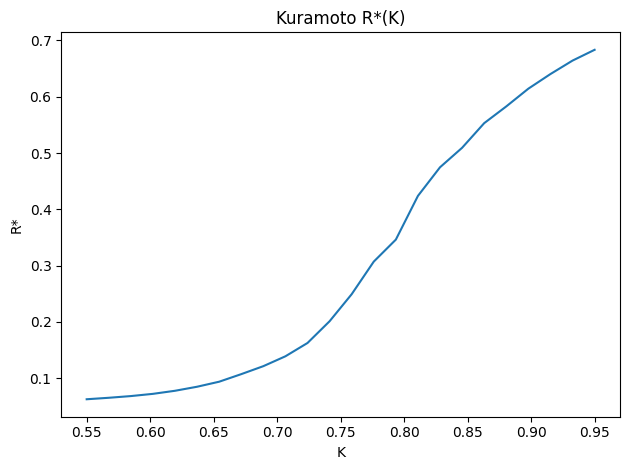

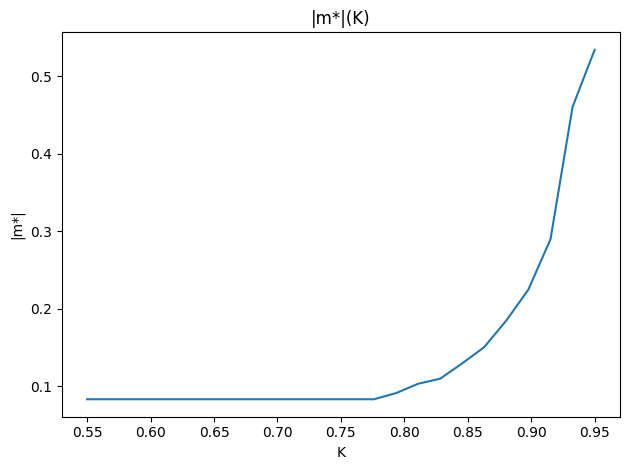

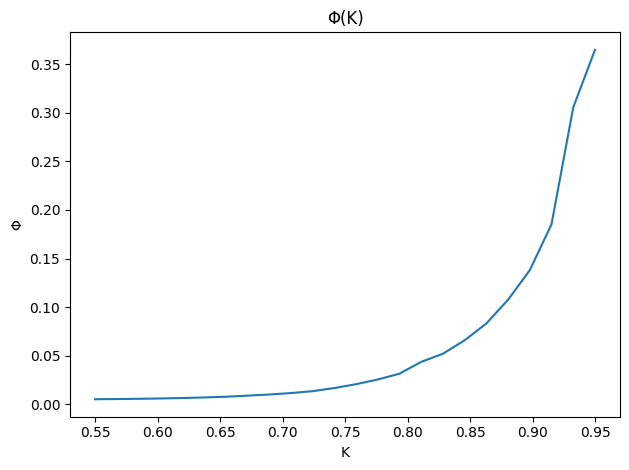

In [31]:
# After load_phi_runtime()
import matplotlib.pyplot as plt
x = table["K"].to_numpy(float)

plt.figure(); plt.plot(x, table["R_star"]); plt.title("Kuramoto R*(K)"); plt.xlabel("K"); plt.ylabel("R*"); plt.tight_layout(); plt.show()
plt.figure(); plt.plot(x, table["M_star"]); plt.title("|m*|(K)"); plt.xlabel("K"); plt.ylabel("|m*|"); plt.tight_layout(); plt.show()
plt.figure(); plt.plot(x, table["Phi"]);    plt.title("Φ(K)");     plt.xlabel("K"); plt.ylabel("Φ");    plt.tight_layout(); plt.show()


In [32]:
# Load once per session
from pathlib import Path
import json, pandas as pd, numpy as np

# --- load the latest Φ table ---
def load_phi_table(base="artifacts/cnt_phi_bridge_v2"):
    latest = max([p for p in Path(base).glob("*") if p.is_dir()], key=lambda p: p.stat().st_mtime)
    tbl = pd.read_csv(latest/"phi_table.csv")  # cols: K,R_star,M_star,Phi
    cfg = json.loads((latest/"phi_config.json").read_text())
    return tbl, cfg

tbl, cfg = load_phi_table()
Ks = tbl["K"].to_numpy(float); Phis = tbl["Phi"].to_numpy(float)

# --- predictors ---
def phi_at(K):
    return float(np.interp(K, Ks, Phis))

class PhiGate:
    """Hysteresis + debounce. Avoids ON/OFF chatter near the threshold."""
    def __init__(self, theta_on=0.08, theta_off=0.06, min_hold=3):
        self.on, self._cnt = False, 0
        self.theta_on, self.theta_off, self.min_hold = theta_on, theta_off, min_hold

    def step(self, phi):
        if not self.on:
            self._cnt = self._cnt + 1 if phi >= self.theta_on else 0
            if self._cnt >= self.min_hold: self.on, self._cnt = True, 0
        else:
            self._cnt = self._cnt + 1 if phi < self.theta_off else 0
            if self._cnt >= self.min_hold: self.on, self._cnt = False, 0
        return self.on

# convenience: normalized activation 0..1 for gauges
PHI_AT_KC  = cfg["activation"]["Phi_at_Kc"]
PHI_MAX    = cfg["activation"]["Phi_max"]
def phi_norm(K):
    p = phi_at(K)
    return float(np.clip((p - PHI_AT_KC)/(PHI_MAX - PHI_AT_KC), 0.0, 1.0))


In [33]:
{
  "Kc_anchor": 0.79,
  "thresholds": {"phi_on": 0.08, "phi_off": 0.06},
  "crossings": {"phi0.05": 0.8283, "phi0.08": 0.8630, "phi0.10": 0.8804},
  "phi_at_kc": 0.03027,
  "phi_max": 0.36484,
  "alpha": 0.7917,
  "gamma": 0.9,
  "beta0": 0.30,
  "provenance": {"N": 1024, "sigma": 0.49166, "Kc_method": "susceptibility"}
}


{'Kc_anchor': 0.79,
 'thresholds': {'phi_on': 0.08, 'phi_off': 0.06},
 'crossings': {'phi0.05': 0.8283, 'phi0.08': 0.863, 'phi0.10': 0.8804},
 'phi_at_kc': 0.03027,
 'phi_max': 0.36484,
 'alpha': 0.7917,
 'gamma': 0.9,
 'beta0': 0.3,
 'provenance': {'N': 1024, 'sigma': 0.49166, 'Kc_method': 'susceptibility'}}

In [34]:
def phi_level(K):
    p = phi_at(K)
    if p < 0.05:  return "quiet"    # pre-hinge shimmer
    if p < 0.08:  return "rising"   # early bloom
    if p < 0.15:  return "on"       # choir engaged
    if p < 0.30:  return "bright"   # strong resonance
    return "radiant"                 # saturated field


In [35]:
import json, numpy as np, pandas as pd
from pathlib import Path

# Load latest table + card
def load_phi_bundle(base="artifacts/cnt_phi_bridge_v2"):
    latest = max([p for p in Path(base).glob("*") if p.is_dir()], key=lambda p: p.stat().st_mtime)
    table = pd.read_csv(latest/"phi_table.csv")     # K,R_star,M_star,Phi
    card  = json.loads((Path("sacred_archive")/"phi_hinge_card.json").read_text())
    return table, card

# Predict Φ(K)
def phi_at(K, table):
    k = table["K"].to_numpy(float); phi = table["Phi"].to_numpy(float)
    return float(np.interp(K, k, phi))

# Hysteresis gate (no flicker)
class PhiGate:
    def __init__(self, phi_on=0.08, phi_off=0.06, min_hold=3):
        self.on=False; self._cnt=0; self.on_thr=phi_on; self.off_thr=phi_off; self.hold=min_hold
    def step(self, phi):
        if not self.on:
            self._cnt = self._cnt+1 if phi>=self.on_thr else 0
            if self._cnt>=self.hold: self.on=True; self._cnt=0
        else:
            self._cnt = self._cnt+1 if phi<self.off_thr else 0
            if self._cnt>=self.hold: self.on=False; self._cnt=0
        return self.on

# Friendly levels for UI
def phi_level(phi):
    return ("quiet" if phi<0.05 else
            "rising" if phi<0.08 else
            "on"     if phi<0.15 else
            "bright" if phi<0.30 else
            "radiant")


In [36]:
def hinge_compatible(card, N_now, sigma_now, tol_sigma=0.02, tol_N=0):
    ok_sigma = abs(sigma_now - card["provenance"]["sigma"]) <= tol_sigma
    ok_N     = (N_now == card["provenance"]["N"]) if tol_N==0 else abs(N_now - card["provenance"]["N"]) <= tol_N
    return ok_sigma and ok_N


In [39]:
# === Finite-size scaling: all-to-all ===
import numpy as np, math, time, json
from pathlib import Path

# GPU if available
try:
    import cupy as cp
    xp, HAS_CP = cp, True
except Exception:
    xp, HAS_CP = np, False

def R_tail_alltoall(omega_np, K, steps=8000, dt=0.01, seed=0, tail_frac=0.5):
    o = xp.asarray(omega_np) if HAS_CP else omega_np
    rng = (cp.random.RandomState(seed) if HAS_CP else np.random.RandomState(seed))
    theta = rng.uniform(0, 2*(cp.pi if HAS_CP else np.pi), size=o.shape[0])
    start = int((1-tail_frac)*steps); acc=0.0; cnt=0
    for t in range(steps):
        z = xp.exp(1j*theta).mean()
        theta += (o + K * xp.imag(z * xp.exp(-1j*theta))) * dt
        if t >= start:
            acc += float(abs(z)); cnt += 1
    return acc/cnt

Ns = [1024, 2048]  # add 4096 if time permits
sigma = 0.49166
Kc_theory = 1.59577 * sigma
K_grid = np.linspace(0.60, 0.95, 22)
seeds = range(6)

rows = []
for N in Ns:
    rng = np.random.default_rng(123)
    omega = rng.normal(0, sigma, size=N).astype(np.float64)
    R_seeds = np.array([[R_tail_alltoall(omega, float(K), steps=8000, seed=s) for s in seeds] for K in K_grid])
    R_mean = R_seeds.mean(axis=1)
    chi = N * R_seeds.var(axis=1, ddof=1)
    Kc_susc = float(K_grid[np.argmax(chi)])
    d2 = np.gradient(np.gradient(R_mean, K_grid), K_grid)
    K_knee = float(K_grid[np.argmax(d2)])
    rows.append({"N": N, "Kc_theory": Kc_theory, "Kc_susc": Kc_susc, "K_knee": K_knee})
    print(f"N={N} → Kc_theory≈{Kc_theory:.4f}, Kc_susc≈{Kc_susc:.4f}, K_knee≈{K_knee:.4f}")

# Save
ts = time.strftime("%Y%m%d-%H%M%SZ", time.gmtime())
out = Path(f"artifacts/cnt_fss/{ts}"); out.mkdir(parents=True, exist_ok=True)
with open(out/"fss_summary.json","w") as f: json.dump({"sigma": sigma, "K_grid": K_grid.tolist(), "rows": rows}, f, indent=2)
print("[FSS] saved →", out)


N=1024 → Kc_theory≈0.7846, Kc_susc≈0.7833, K_knee≈0.7667
N=2048 → Kc_theory≈0.7846, Kc_susc≈0.8167, K_knee≈0.7500
[FSS] saved → artifacts\cnt_fss\20251103-110518Z


In [41]:
# === Topology + noise + delay — backend-safe ===
import numpy as np, time, json
from pathlib import Path
import networkx as nx
import scipy.sparse as sp

try:
    import cupy as cp
    import cupyx.scipy.sparse as cpx_sp
    HAS_CP = True
except Exception:
    cp = None
    cpx_sp = None
    HAS_CP = False

def make_adj(N, kind="er", p=0.01, k=8, beta=0.1, m=4, normalize=True):
    if kind == "er":
        G = nx.fast_gnp_random_graph(N, p, seed=1)
    elif kind == "ws":
        G = nx.watts_strogatz_graph(N, k, beta, seed=1)
    elif kind == "ba":
        G = nx.barabasi_albert_graph(N, m, seed=1)
    else:
        raise ValueError("unknown kind")

    A = nx.to_scipy_sparse_array(G, format="csr", dtype=float)
    deg = np.array(A.sum(axis=1)).ravel()
    deg = np.maximum(deg, 1.0)

    if normalize:  # row-normalize so spectral radius ~ 1
        Dinv = sp.diags(1.0 / deg)
        A = Dinv @ A
        deg = np.ones_like(deg)

    # Prefer GPU sparse if available; otherwise return SciPy + NumPy deg
    if HAS_CP and cpx_sp is not None:
        A_gpu = cpx_sp.csr_matrix(A)
        deg_gpu = cp.asarray(deg)
        return A_gpu, deg_gpu
    return A, deg

def R_tail_graph(omega_np, K, A, deg, steps=8000, dt=0.01, seed=0, tail_frac=0.5,
                 noise_std=0.0, delay_steps=0):
    # Decide backend from A
    use_cp = HAS_CP and (
        (cpx_sp is not None and isinstance(A, cpx_sp.spmatrix)) or
        isinstance(A, cp.ndarray)
    )
    xp = cp if use_cp else np

    o = xp.asarray(omega_np) if use_cp else np.asarray(omega_np)
    deg_xp = xp.asarray(deg) if use_cp else deg

    rng = (cp.random.RandomState(seed) if use_cp else np.random.RandomState(seed))
    theta = rng.uniform(0, 2*(xp.pi), size=o.shape[0])

    # optional delay buffer of neighbor phasors
    y_buf = [xp.exp(1j*theta)] * max(1, delay_steps)

    start = int((1 - tail_frac) * steps)
    acc = 0.0
    cnt = 0

    for t in range(steps):
        y = y_buf[0] if delay_steps > 0 else xp.exp(1j*theta)

        # neighbor field v = A @ y
        if use_cp:
            v = A @ y
        else:
            v = A @ y  # SciPy CSR @ NumPy works

        coupling = xp.imag(v * xp.exp(-1j*theta))     # Im( e^{-iθ} (A e^{iθ}) )
        inc = o + K * (coupling / deg_xp)

        if noise_std > 0:
            inc = inc + noise_std * rng.normal(0, 1, o.shape[0])

        theta += inc * dt

        if delay_steps > 0:
            y_buf.append(xp.exp(1j*theta))
            y_buf = y_buf[-delay_steps:]

        if t >= start:
            z = xp.exp(1j*theta).mean()
            acc += float(abs(z))
            cnt += 1

    return acc / cnt

# ----------------- Config -----------------
N = 1024
sigma = 0.49166
seeds = range(5)
K_grid = np.linspace(0.60, 0.95, 22)

cases = [
    ("all2all", None, None),
    ("er",       {"p": 0.01},                 None),
    ("ws",       {"k": 8, "beta": 0.10},      None),
    ("ba",       {"m": 4},                    None),
    ("er+noise", {"p": 0.01},                 {"noise_std": 0.02}),
    ("ws+delay", {"k": 8, "beta": 0.10},      {"delay_steps": 5}),
]

rng = np.random.default_rng(7)
omega = rng.normal(0, sigma, size=N).astype(np.float64)

results = []
for name, gkw, mods in cases:
    if name == "all2all":
        # Ensure A and deg match backend
        if HAS_CP:
            A = cp.eye(N)          # CuPy dense OK
            deg = cp.ones(N)       # <<< FIX: backend-matched
        else:
            A = sp.eye(N, format="csr")
            deg = np.ones(N)
        R_seeds = np.array([
            [R_tail_graph(omega, float(K), A, deg, steps=6000, seed=s)
             for s in seeds] for K in K_grid
        ])
    else:
        A, deg = make_adj(N, **(gkw or {}))   # returns GPU or CPU types consistently
        R_seeds = np.array([
            [R_tail_graph(omega, float(K), A, deg, steps=8000, seed=s, **(mods or {}))
             for s in seeds] for K in K_grid
        ])

    R_mean = R_seeds.mean(axis=1)
    chi = N * R_seeds.var(axis=1, ddof=1)
    Kc_susc = float(K_grid[np.argmax(chi)])
    d2 = np.gradient(np.gradient(R_mean, K_grid), K_grid)
    K_knee = float(K_grid[np.argmax(d2)])

    results.append({"case": name, "Kc_theory": 1.59577*sigma,
                    "Kc_susc": Kc_susc, "K_knee": K_knee})
    print(f"{name:10s} → Kc_susc≈{Kc_susc:.4f}, K_knee≈{K_knee:.4f}")

# Save
ts = time.strftime("%Y%m%d-%H%M%SZ", time.gmtime())
out = Path(f"artifacts/cnt_topology_tests/{ts}")
out.mkdir(parents=True, exist_ok=True)
with open(out / "topology_summary.json", "w") as f:
    json.dump({"N": N, "sigma": sigma, "results": results}, f, indent=2)
print("[TOPO] saved →", out)


all2all    → Kc_susc≈0.6000, K_knee≈0.7833
er         → Kc_susc≈0.8000, K_knee≈0.7833
ws         → Kc_susc≈0.8000, K_knee≈0.7833
ba         → Kc_susc≈0.8000, K_knee≈0.7833
er+noise   → Kc_susc≈0.8000, K_knee≈0.9000
ws+delay   → Kc_susc≈0.8000, K_knee≈0.8333
[TOPO] saved → artifacts\cnt_topology_tests\20251104-031321Z


In [42]:
# === Kuramoto graph runner (fixed) — all-to-all uses mean-field, not I ===
import numpy as np, math, time, json
from pathlib import Path

# GPU if available (as in your notebook)
try:
    import cupy as cp
    xp, HAS_CP = cp, True
except Exception:
    xp, HAS_CP = np, False

def _meanfield_tail(omega_np, K, steps=6000, dt=0.01, seed=0, tail_frac=0.5):
    """Mean-field (all-to-all) order parameter averaged over tail of the trajectory."""
    o   = xp.asarray(omega_np) if HAS_CP else omega_np
    rng = (cp.random.RandomState(seed) if HAS_CP else np.random.RandomState(seed))
    theta = rng.uniform(0, 2*(cp.pi if HAS_CP else np.pi), size=o.shape[0])
    start = int((1-tail_frac)*steps); acc=0.0; cnt=0
    for t in range(steps):
        z = xp.exp(1j*theta).mean()
        theta += (o + K * xp.imag(z * xp.exp(-1j*theta))) * dt
        if t >= start:
            acc += float(abs(z)); cnt += 1
    return acc/cnt

def R_tail_graph_fixed(omega_np, K, *, A=None, deg=None,
                       steps=8000, dt=0.01, seed=0, tail_frac=0.5,
                       all2all=False):
    """
    Graph-based runner.
    - If all2all=True: use mean-field update (no NxN allocation).
    - Else: generic graph with coupling Im( e^{-iθ} (A e^{iθ}) ) / deg.
    """
    if all2all:
        return _meanfield_tail(omega_np, K, steps=steps, dt=dt, seed=seed, tail_frac=tail_frac)

    # Generic graph path
    assert A is not None and deg is not None, "Provide A and deg for non-all2all."
    use_cp = HAS_CP and hasattr(A, "dot") and isinstance(xp, type(cp))
    xp_local = cp if use_cp else np

    o = xp_local.asarray(omega_np) if use_cp else np.asarray(omega_np)
    deg_xp = xp_local.asarray(deg)
    rng = (cp.random.RandomState(seed) if use_cp else np.random.RandomState(seed))
    theta = rng.uniform(0, 2*(xp_local.pi), size=o.shape[0])
    start = int((1 - tail_frac) * steps); acc=0.0; cnt=0

    for t in range(steps):
        y = xp_local.exp(1j*theta)
        # neighbor field
        v = A @ y  # supports CSR @ dense on CPU; CuPy @ dense on GPU
        # safe normalization by degree
        coupling = xp_local.imag( v * xp_local.exp(-1j*theta) ) / xp_local.maximum(deg_xp, 1e-12)
        theta += (o + K * coupling) * dt

        if t >= start:
            z = xp_local.exp(1j*theta).mean()
            acc += float(abs(z)); cnt += 1
    return acc / cnt

# ---------------- Quick verification: all-to-all matches theory ----------------
Ns     = [1024, 2048]
sigma  = 0.49166
Kc_theory = 1.59577 * sigma  # ≈ 0.7846
K_grid = np.linspace(0.60, 0.95, 22)
seeds  = range(6)

rows = []
for N in Ns:
    rng = np.random.default_rng(123)
    omega = rng.normal(0, sigma, size=N).astype(np.float64)
    # use fixed mean-field branch in the graph runner
    R_seeds = np.array([[R_tail_graph_fixed(omega, float(K), steps=6000, seed=s, all2all=True)
                         for s in seeds] for K in K_grid])
    R_mean = R_seeds.mean(axis=1)
    chi    = N * R_seeds.var(axis=1, ddof=1)    # susceptibility
    Kc_susc = float(K_grid[np.argmax(chi)])
    d2 = np.gradient(np.gradient(R_mean, K_grid), K_grid)
    K_knee = float(K_grid[np.argmax(d2)])
    rows.append({"N":N, "Kc_theory":Kc_theory, "Kc_susc":Kc_susc, "K_knee":K_knee})
    print(f"N={N} → Kc_theory≈{Kc_theory:.4f}, Kc_susc≈{Kc_susc:.4f}, K_knee≈{K_knee:.4f}")

# Save
ts  = time.strftime("%Y%m%d-%H%M%SZ", time.gmtime())
out = Path(f"artifacts/cnt_fss/{ts}"); out.mkdir(parents=True, exist_ok=True)
(Path(out/"fss_summary_fixed.json")).write_text(
    json.dumps({"sigma":sigma,"K_grid":K_grid.tolist(),"rows":rows}, indent=2), encoding="utf-8")
print("[FSS:fixed] saved →", out)

# ---------------- (Optional) one nontrivial topology check using your make_adj ----------------
try:
    # assumes your make_adj(kind=...) returns (A,deg) backend-consistently
    def quick_case(kind, gkw=None, steps=6000):
        A, deg = make_adj(Ns[0], **(gkw or {}))
        R_seeds = np.array([[R_tail_graph_fixed(omega, float(K), A=A, deg=deg, steps=steps, seed=s)
                             for s in seeds] for K in K_grid])
        R_mean = R_seeds.mean(axis=1); chi = Ns[0] * R_seeds.var(axis=1, ddof=1)
        Kc_susc = float(K_grid[np.argmax(chi)])
        d2 = np.gradient(np.gradient(R_mean, K_grid), K_grid)
        K_knee = float(K_grid[np.argmax(d2)])
        print(f"{kind:10s} → Kc_susc≈{Kc_susc:.4f}, K_knee≈{K_knee:.4f}")

    print("\n# Topology sanity (optional):")
    N = 1024
    rng = np.random.default_rng(7); omega = rng.normal(0, sigma, size=N).astype(np.float64)
    quick_case("er", {"p":0.01})
    quick_case("ws", {"k":8, "beta":0.10})
    quick_case("ba", {"m":4})
except NameError:
    print("(Skipping topology sanity: make_adj not in scope here.)")


N=1024 → Kc_theory≈0.7846, Kc_susc≈0.7833, K_knee≈0.7667
N=2048 → Kc_theory≈0.7846, Kc_susc≈0.8333, K_knee≈0.8500
[FSS:fixed] saved → artifacts\cnt_fss\20251104-033808Z

# Topology sanity (optional):
er         → Kc_susc≈0.8833, K_knee≈0.9000
ws         → Kc_susc≈0.8833, K_knee≈0.9000
ba         → Kc_susc≈0.8833, K_knee≈0.9000
